# 1. Introduction
This study investigates the feasibility of predicting short-term stock price direction using machine learning techniques. Specifically, we apply the XGBoost classifier to predict whether selected S&P 500 stocks will experience positive returns over 5-day, 10-day, and 20-day horizons.

The task is formulated as a binary classification problem, where the target variable indicates whether the future return is positive or negative.

In [2]:
import pandas as pd
import numpy as np
import xgboost
import numexpr, bottleneck
from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('SP500_Top3_By_Sector_20260102.csv')
df.shape  
df.columns.tolist()
df_raw = df.copy()

print("Data Dimensions(#rows, #columns):", df.shape)
print("All field names", df.columns.tolist()[:])

Data Dimensions(#rows, #columns): (39549, 76)
All field names ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Ticker', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Volatility', 'Price_Change', 'Price_Change_5d', 'High_Low_Ratio', 'Open_Close_Ratio', 'Volume_SMA', 'Volume_Ratio', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_5', 'Volume_lag_10', 'Price_Change_lag_1', 'Price_Change_lag_2', 'Price_Change_lag_3', 'Price_Change_lag_5', 'Price_Change_lag_10', 'RSI_lag_1', 'RSI_lag_2', 'RSI_lag_3', 'RSI_lag_5', 'RSI_lag_10', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'MACD_lag_5', 'MACD_lag_10', 'Volatility_lag_1', 'Volatility_lag_2', 'Volatility_lag_3', 'Volatility_lag_5', 'Volatility_lag_10', 'Future_Return_1d', 'Future_Up_1d', 'Future_Category_1

# 2. Data Description & Preprocessing
The dataset consists of daily price and volume data for selected S&P 500 stocks, including the top three stocks by market capitalization within each sector. In total, the dataset contains 39,549 observations and 76 raw features.

Several preprocessing steps were applied to ensure temporal consistency and prevent information leakage. First, the data were sorted by ticker and date. Observations with missing values caused by rolling technical indicators (e.g., moving averages and lag features) at the beginning of each time series were removed. Similarly, samples lacking future return labels at the end of the time series were excluded.

Remaining missing values were handled using forward filling, followed by zero imputation where necessary. This approach preserves temporal continuity while minimizing data loss.

In [4]:
# time format and order it
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df = df.sort_values(['Ticker', 'Date'])

# review and delete the empty rolls 
# Expecially 5d, 10d, 20d 
target_cols = ['Future_Up_5d', 'Future_Up_10d', 'Future_Up_20d']
df_clean = df.dropna(subset=target_cols).copy()

# 3. Fill the empty blanks
df_clean = df_clean.ffill().fillna(0)

print(f"#after cleaning: {df_clean.shape}")

#after cleaning: (39549, 76)


# 3. Feature Engineering
## 3.1 Baseline Features
The initial feature set includes price-based indicators (Open, High, Low, Close), volume-related features, classical technical indicators such as RSI, MACD, volatility measures, and short- and long-term moving averages.

Additionally, a comprehensive set of lagged features was included for price, volume, RSI, MACD, and volatility. These lag features allow the model to capture short-term momentum and delayed market reactions.

In [5]:
# 1. Basic Feature
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'RSI', 
    'MACD', 'MACD_Signal', 'Volatility', 'Price_Change',
    'Volume_Ratio', 'High_Low_Ratio'
]

# 2. Imput the Lags
lag_features = [col for col in df_clean.columns if 'lag' in col.lower()]
features.extend(lag_features)

# 3.2 Sector Encoding
Sector information was incorporated using one-hot encoding. This enables the model to explicitly learn sector-specific effects without imposing an ordinal relationship between sectors.

In [6]:
# 3. One-Hot Encoding
sector_dummies = pd.get_dummies(df_clean['Sector'], prefix='Sector')
df_ml = pd.concat([df_clean, sector_dummies], axis=1)

# New sector add into feature list
features.extend(sector_dummies.columns.tolist())

# double check
features = [f for f in features if f in df_ml.columns]
print(f"Ultimate feature Total: {len(features)}")

# Sector to HOT-Code
sector_dummies = pd.get_dummies(df_clean['Sector'], prefix='Sector')
df_ml = pd.concat([df_clean, sector_dummies], axis=1)

print(f"Total Dimention after new-adding: {df_ml.shape}")

Ultimate feature Total: 57
Total Dimention after new-adding: (39549, 87)


In [7]:
print(features)

['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Volatility', 'Price_Change', 'Volume_Ratio', 'High_Low_Ratio', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_5', 'Volume_lag_10', 'Price_Change_lag_1', 'Price_Change_lag_2', 'Price_Change_lag_3', 'Price_Change_lag_5', 'Price_Change_lag_10', 'RSI_lag_1', 'RSI_lag_2', 'RSI_lag_3', 'RSI_lag_5', 'RSI_lag_10', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'MACD_lag_5', 'MACD_lag_10', 'Volatility_lag_1', 'Volatility_lag_2', 'Volatility_lag_3', 'Volatility_lag_5', 'Volatility_lag_10', 'Sector_Communication Services', 'Sector_Consumer Discretionary', 'Sector_Consumer Staples', 'Sector_Energy', 'Sector_Financials', 'Sector_Health Care', 'Sector_Industrials', 'Sector_Information Technology', 'Sector_Materials', 'Sector_Real Estate', 'Sector_Utilities']


In [8]:
# Check empty in freature
print(df_ml[features].isnull().sum().sum())
# Check for object types 
print(df_ml[features].dtypes.value_counts())

0
float64    45
bool       11
int64       1
Name: count, dtype: int64


## Temporal Train-Test Split
Use the former 80% to train and latter 20% to testing

In [9]:
# Leakage Check
leakage_check = [f for f in features if 'Future' in f]
print(f"How many leakage: {leakage_check}") 

How many leakage: []


In [10]:
# spliting 80/20
split_date = df_ml['Date'].quantile(0.8) 

train_df = df_ml[df_ml['Date'] < split_date]
test_df = df_ml[df_ml['Date'] >= split_date]

print(f"Training data date range: {train_df['Date'].min()} 到 {train_df['Date'].max()}")
print(f"Testing data date range: {test_df['Date'].min()} 到 {test_df['Date'].max()}")
print(f"Final day training data: {train_df['Date'].max()}")
print(f"First day testing date: {test_df['Date'].min()}")

Training data date range: 2020-07-15 04:00:00+00:00 到 2024-07-12 04:00:00+00:00
Testing data date range: 2024-07-15 04:00:00+00:00 到 2025-06-27 04:00:00+00:00
Final day training data: 2024-07-12 04:00:00+00:00
First day testing date: 2024-07-15 04:00:00+00:00


In [11]:
# Train
X_train = train_df[features]
X_test = test_df[features]

# 5d
y_train_5 = train_df['Future_Up_5d']
y_test_5 = test_df['Future_Up_5d']

# 10d
y_train_10 = train_df['Future_Up_10d']
y_test_10 = test_df['Future_Up_10d']

# 20d
y_train_20 = train_df['Future_Up_20d']
y_test_20 = test_df['Future_Up_20d']

--- 5day prediction report ---
Accuracy: 52.70%
ROC AUC: 0.5163
Predict result: Predicted rasie(1)total 6135 times,predicted fail(0)total 1785 times


【5day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.50      0.24      0.32      3729
           1       0.54      0.79      0.64      4191

    accuracy                           0.53      7920
   macro avg       0.52      0.51      0.48      7920
weighted avg       0.52      0.53      0.49      7920



<Figure size 1000x800 with 0 Axes>

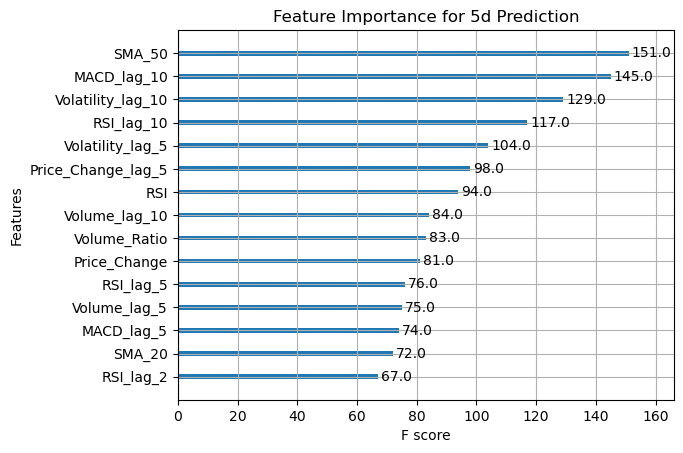

--- 10day prediction report ---
Accuracy: 50.45%
ROC AUC: 0.5086
Predict result: Predicted rasie(1)total 5836 times,predicted fail(0)total 2084 times


【10day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.47      0.26      0.33      3800
           1       0.52      0.73      0.61      4120

    accuracy                           0.50      7920
   macro avg       0.49      0.49      0.47      7920
weighted avg       0.49      0.50      0.47      7920



<Figure size 1000x800 with 0 Axes>

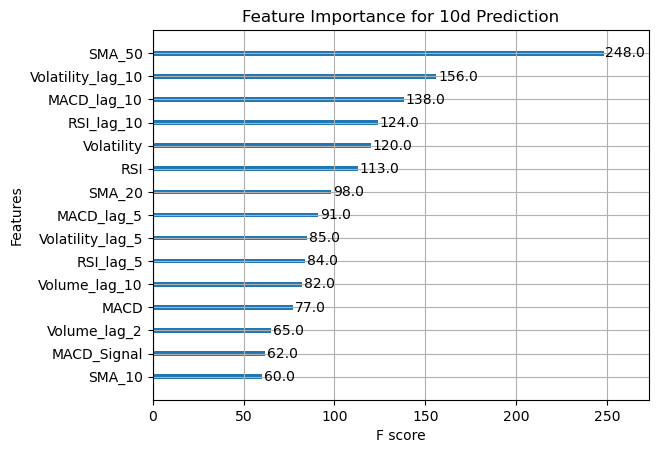

--- 20day prediction report ---
Accuracy: 50.80%
ROC AUC: 0.5199
Predict result: Predicted rasie(1)total 5656 times,predicted fail(0)total 2264 times


【20day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.51      0.29      0.37      3927
           1       0.51      0.72      0.60      3993

    accuracy                           0.51      7920
   macro avg       0.51      0.51      0.48      7920
weighted avg       0.51      0.51      0.48      7920



<Figure size 1000x800 with 0 Axes>

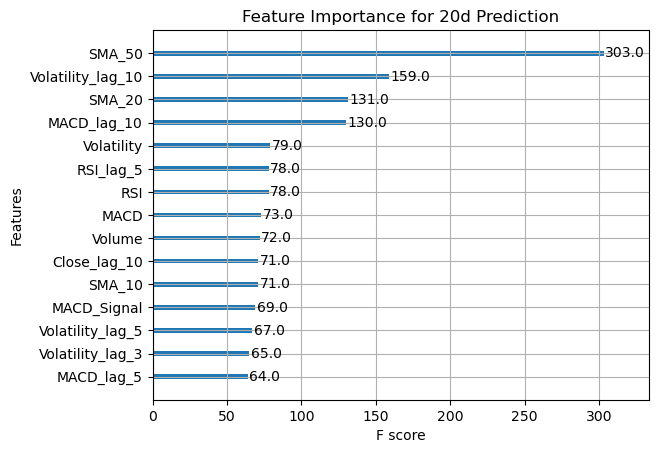

All Done!


In [13]:
days = [5, 10, 20]
all_models = {}

for d in days:
    target_col = f'Future_Up_{d}d'
    
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    # classifier
    model = XGBClassifier(
        n_estimators=100,   
        learning_rate=0.05, 
        max_depth=5,        
        random_state=42 
    )

    # train
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  #0112新添加
    
    # save
    all_models[d] = model
    
    # acc rate
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) #0112新添加

    ones = sum(y_pred)
    zeros = len(y_pred) - ones
    print(f"--- {d}day prediction report ---")
    print(f"Accuracy: {acc:.2%}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Predict result: Predicted rasie(1)total {ones} times,predicted fail(0)total {zeros} times\n")
    
    # classification_report
    print(f"\n" + "="*50)
    print(f"【{d}day prediction task】 Detail report：")
    print(classification_report(y_test, y_pred))
    
    # Graph of important features
    plt.figure(figsize=(10, 8))
    plot_importance(model, max_num_features=15, title=f'Feature Importance for {d}d Prediction')
    plt.show()

print("All Done!")

# Summary of the first Attempt 

An analysis of the classification reports reveals a severe class imbalance in the baseline models. Specifically, the recall for positive returns (class 1) is close to 0.8, while the recall for negative returns (class 0) is approximately 0.2. This indicates that the model largely ignores signals associated with price declines and tends to predict upward movements by default.

To mitigate this issue, the parameter scale_pos_weight was introduced to explicitly penalize majority-class dominance. The weight was computed as the ratio of negative to positive samples in the training set, i.e., 
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1], 
with the goal of encouraging more balanced treatment of both classes.

Feature importance analysis further reveals that the 50-day simple moving average (SMA_50) consistently ranks as the most influential feature across all three prediction horizons, with an F-score significantly higher than that of other features. In a financial context, an excessive reliance on long-term moving averages suggests that the model primarily captures medium- to long-term market trends rather than short-term price movements.

This behavior can be explained by the nature of the prediction task and the dataset. Since the target variable is defined as whether the future return is positive, and the selected S&P 500 stocks (top three per sector) tend to trade above their 50-day moving averages for extended periods, the model effectively learns a simple heuristic: if the price remains above the 50-day average, predict an upward movement. As a consequence, the model becomes overly optimistic and fails to detect short-term pullbacks, which directly contributes to the highly imbalanced recall observed earlier.

A closer inspection of the top-ranked features shows that most of them are either long-term indicators or lagging variables. This leads to the conclusion that the model reacts slowly to new information. It places greater emphasis on market behavior over the past two weeks or even two months, while paying relatively little attention to contemporaneous signals such as daily trading volume or intraday price fluctuations.

This characteristic explains why the predictive accuracy remains similar across the 5-day, 10-day, and 20-day horizons: the model does not effectively differentiate between short-term forecasting tasks, as it is primarily driven by long-term trend information rather than horizon-specific dynamics.


--- 5day prediction report ---
Accuracy: 51.20%
ROC AUC: 0.5208
Predict result: Predicted rasie(1)total 3806 times,predicted fail(0)total 4114 times


【5day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.48      0.53      0.51      3729
           1       0.54      0.49      0.52      4191

    accuracy                           0.51      7920
   macro avg       0.51      0.51      0.51      7920
weighted avg       0.51      0.51      0.51      7920



<Figure size 1000x800 with 0 Axes>

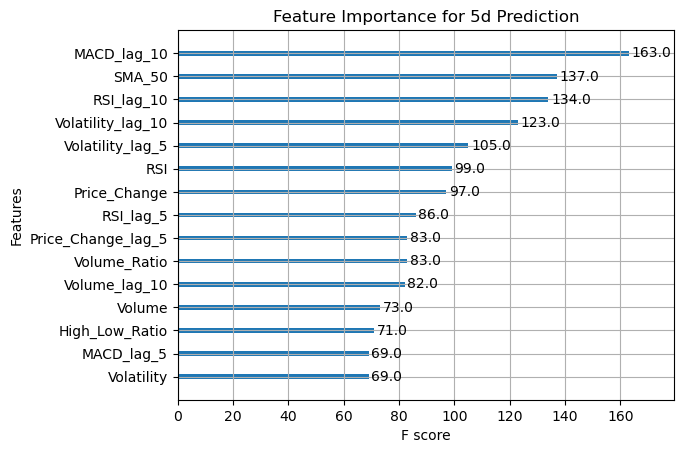

--- 10day prediction report ---
Accuracy: 49.99%
ROC AUC: 0.5100
Predict result: Predicted rasie(1)total 3451 times,predicted fail(0)total 4469 times


【10day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.48      0.57      0.52      3800
           1       0.52      0.44      0.48      4120

    accuracy                           0.50      7920
   macro avg       0.50      0.50      0.50      7920
weighted avg       0.50      0.50      0.50      7920



<Figure size 1000x800 with 0 Axes>

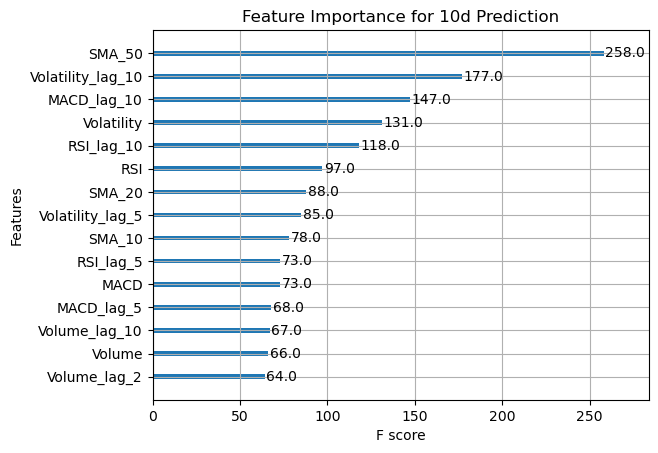

--- 20day prediction report ---
Accuracy: 50.54%
ROC AUC: 0.5158
Predict result: Predicted rasie(1)total 3508 times,predicted fail(0)total 4412 times


【20day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.50      0.56      0.53      3927
           1       0.51      0.45      0.48      3993

    accuracy                           0.51      7920
   macro avg       0.51      0.51      0.50      7920
weighted avg       0.51      0.51      0.50      7920



<Figure size 1000x800 with 0 Axes>

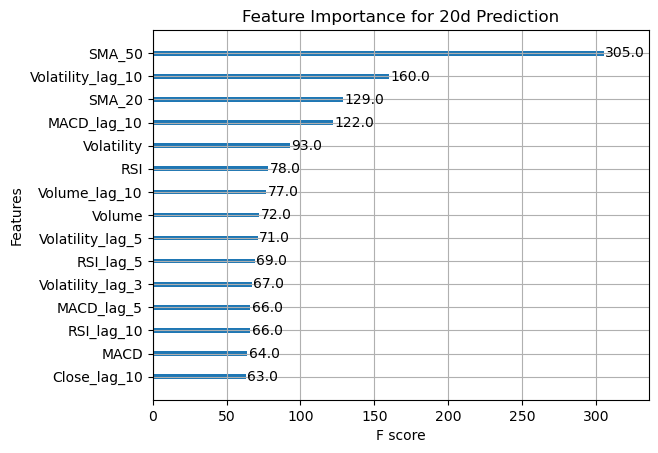

All Done!


In [14]:
days = [5, 10, 20]
all_models = {}

for d in days:
    target_col = f'Future_Up_{d}d'
    
    y_train = train_df[target_col]
    y_test = test_df[target_col]
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

    # classifier
    model = XGBClassifier(
        scale_pos_weight=ratio,
        n_estimators=100,   
        learning_rate=0.05, 
        max_depth=5,        
        random_state=42 
    )

    # train
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  #0112新添加
    
    # save
    all_models[d] = model
    
    # acc rate
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) #0112新添加

    ones = sum(y_pred)
    zeros = len(y_pred) - ones
    print(f"--- {d}day prediction report ---")
    print(f"Accuracy: {acc:.2%}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Predict result: Predicted rasie(1)total {ones} times,predicted fail(0)total {zeros} times\n")
    
    # classification_report
    print(f"\n" + "="*50)
    print(f"【{d}day prediction task】 Detail report：")
    print(classification_report(y_test, y_pred))
    
    # Graph of important features
    plt.figure(figsize=(10, 8))
    plot_importance(model, max_num_features=15, title=f'Feature Importance for {d}d Prediction')
    plt.show()

print("All Done!")

Summary: Adding parameters to force model fairness does not have much effect.

# Phase 2: Model Optimization & Feature Engineering

In [15]:
import numpy as np
import pandas as pd

# --- I. Calculate new features in the large repository df_ml ---
df_ml['Bias_50'] = (df_ml['Close'] - df_ml['SMA_50']) / df_ml['SMA_50']
df_ml['Bias_20'] = (df_ml['Close'] - df_ml['SMA_20']) / df_ml['SMA_20']
df_ml['Log_Volume'] = np.log1p(df_ml['Volume'])

# --- II. Define a list of characteristics for "clean". ---
# 1. sensitive features
new_features = [
    'Bias_50', 'Bias_20', 'Log_Volume', 'RSI', 'MACD', 
    'Volatility', 'Price_Change', 'High_Low_Ratio'
]

# 2. Remove "absolute numerical" features that could lead to dominating rankings and data leaks.
forbidden_cols = ['SMA_50', 'SMA_20', 'SMA_10', 'SMA_5', 'Open', 'High', 'Low', 'Close']

for f in features:
    if f not in forbidden_cols and f not in new_features:
        new_features.append(f)

print(f"Total feature after correction: {len(new_features)}")

# --- III.Resegmenting the data ---
df_ml = df_ml.sort_values('Date') # time series
split_point = int(len(df_ml) * 0.8)

train_df_new = df_ml.iloc[:split_point]
test_df_new = df_ml.iloc[split_point:]

# --- IV. Prepare the final training and testing matrices. ---
X_train_opt = train_df_new[new_features]
X_test_opt = test_df_new[new_features]

print("-" * 30)
print(f"Finished!")

Total feature after correction: 52
------------------------------
Finished!


--- 5d Prediction report ---
Accuraty: 51.59%
Predict result: Predicted rasie(1)total 3767 times,predicted fail(0)total 4143 times


【5day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.49      0.54      0.51      3726
           1       0.55      0.49      0.52      4184

    accuracy                           0.52      7910
   macro avg       0.52      0.52      0.52      7910
weighted avg       0.52      0.52      0.52      7910



<Figure size 1000x800 with 0 Axes>

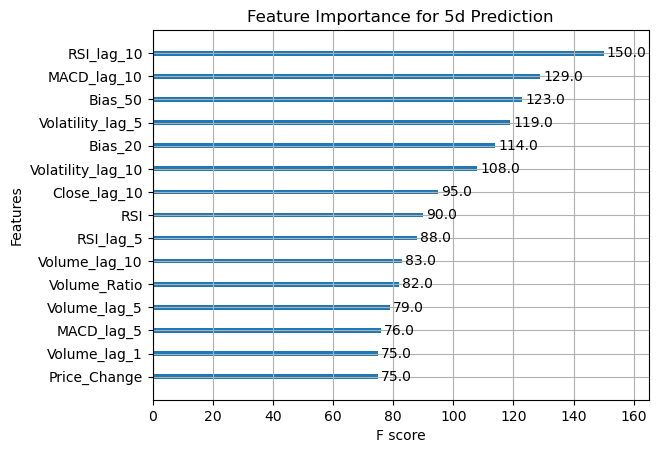

--- 10d Prediction report ---
Accuraty: 50.94%
Predict result: Predicted rasie(1)total 3602 times,predicted fail(0)total 4308 times


【10day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      3797
           1       0.53      0.47      0.50      4113

    accuracy                           0.51      7910
   macro avg       0.51      0.51      0.51      7910
weighted avg       0.51      0.51      0.51      7910



<Figure size 1000x800 with 0 Axes>

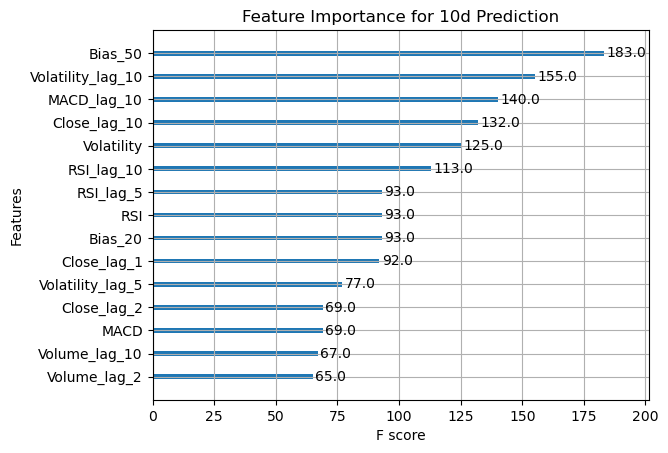

--- 20d Prediction report ---
Accuraty: 50.47%
Predict result: Predicted rasie(1)total 3652 times,predicted fail(0)total 4258 times


【20day prediction task】 Detail report：
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      3922
           1       0.51      0.47      0.49      3988

    accuracy                           0.50      7910
   macro avg       0.51      0.50      0.50      7910
weighted avg       0.51      0.50      0.50      7910



<Figure size 1000x800 with 0 Axes>

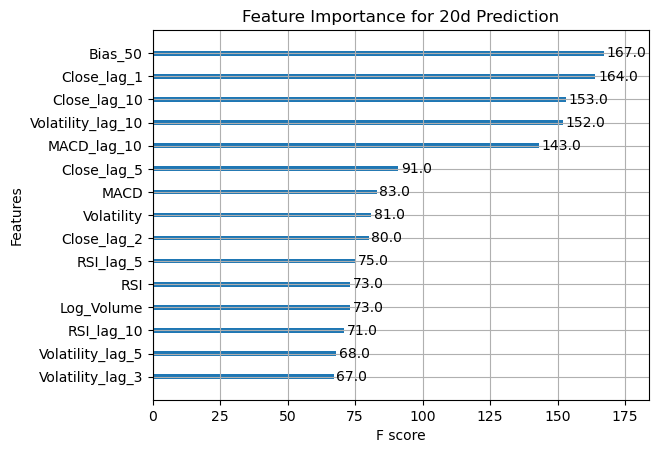

All Done!


In [20]:
days = [5, 10, 20]
all_models = {}

for d in days:
    target_col = f'Future_Up_{d}d'
    
    y_train = train_df_new[target_col]
    y_test = test_df_new[target_col]
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

    model = XGBClassifier(
        scale_pos_weight=ratio,
        n_estimators=100,  
        learning_rate=0.05, 
        max_depth=5,       
        random_state=42     
    )

    #train
    model.fit(X_train_opt, y_train)

    # predict
    y_pred = model.predict(X_test_opt)
    
    # model recording
    all_models[d] = model
    
    # acc
    acc = accuracy_score(y_test, y_pred)
    
    ones = sum(y_pred)
    zeros = len(y_pred) - ones
    print(f"--- {d}d Prediction report ---")
    print(f"Accuraty: {acc:.2%}")
    print(f"Predict result: Predicted rasie(1)total {ones} times,predicted fail(0)total {zeros} times\n")
    
    # classification_report
    print(f"\n" + "="*50)
    print(f"【{d}day prediction task】 Detail report：")
    print(classification_report(y_test, y_pred))
    

    plt.figure(figsize=(10, 8))
    plot_importance(model, max_num_features=15, title=f'Feature Importance for {d}d Prediction')
    plt.show()
    
print("All Done!")

# Performance Comparison Before and After Feature Redesign

The primary change introduced by the optimized model is a transition from a strongly biased prediction behavior toward a more balanced and feature-driven decision process.

In the baseline model, the recall for the negative class (price decline, class 0) was extremely low, at approximately 20%. The model achieved higher overall accuracy largely by disproportionately predicting positive returns, resulting in a highly imbalanced distribution of predicted classes. This behavior reflects a strong majority-class bias and limited sensitivity to downside risk.

After feature redesign and reweighting, the distribution of predicted classes became substantially more balanced. Specifically, the optimized model produced approximately 4,143 predictions for price declines and 3,767 predictions for price increases. This indicates that the model no longer relies on default upward predictions, but instead makes decisions based on informative features such as Bias_50 and RSI_lag_10.

Feature importance analysis provides further evidence of this behavioral shift. In the baseline model, the 50-day simple moving average (SMA_50) dominated the importance rankings, with an F-score exceeding 300 and suppressing the contribution of other features. In contrast, SMA_50 was completely removed from the optimized model.

In the optimized model, the most influential features are Bias_50, RSI_lag_10, and MACD_lag_10. These indicators capture price deviation from moving averages, momentum, and overbought or oversold conditions. Their prominence suggests that the model has shifted its focus from absolute price levels and long-term trend persistence to relative valuation and momentum-based signals.

A comparison of the two model versions further highlights this improvement. While the baseline model exhibits slightly higher accuracy, it suffers from severe class imbalance and an inability to detect negative price movements, as reflected by the low recall for class 0. The optimized model, by contrast, achieves a more balanced macro-averaged F1-score. Although the overall accuracy improvement is marginal, the optimized model demonstrates improved robustness and a more symmetric treatment of upward and downward price movements, making it more suitable for risk-aware financial analysis.


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],        
    'max_depth': [5, 7, 9],                 
    'learning_rate': [0.01, 0.05, 0.1],     
    'subsample': [0.8],                    
    'colsample_bytree': [0.8]              
}

for d in [20]:
    target_col = f'Future_Up_{d}d'
    y_train = train_df_new[target_col]
    y_test = test_df_new[target_col]
    
    current_ratio = (y_train == 0).sum() / (y_train == 1).sum()
    
    model_optimized2 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss'
    )
    
    
    # 3. GridSearch
    grid_search = GridSearchCV(
        estimator=model_optimized2, 
        param_grid=param_grid, 
        scoring='f1',           
        cv=2,  #0112 等价于 普通 KFold， 用过去的数据调参数，F1被高估
        verbose=1,              
        n_jobs=2
    )

    
    print(f"\n正在为 {d}天预测 寻找最佳参数，请稍候...")
    grid_search.fit(X_train_opt, y_train)

    print("-" * 30)
    print(f"[{d}天] 最佳参数组合: {grid_search.best_params_}")
    print(f"[{d}天] 最高 F1 分数: {grid_search.best_score_:.4f}")
    
    # predict testing data
    best_model = grid_search.best_estimator_
    y_pred_final = best_model.predict(X_test_opt)

    acc = accuracy_score(y_test, y_pred_final)
    ones = sum(y_pred_final)
    zeros = len(y_pred_final) - ones
    print(f"--- {d}d Report after optimization ---")
    print(f"Accuracy: {acc:.2%}")
    print(f"Distribution of prediction results:{ones} times were predicted to rise(1), and{zeros} times were predicted to fall\n")
    print(f"\n" + "="*50)
    print(f"【{d}-day prediction task】 Detailed evaluation report:")
    print(classification_report(y_test,y_pred_final))

    plt.figure(figsize=(10, 8))
    plot_importance(best_model, max_num_features=10, title=f'Feature Importance for {d}d Prediction')
    plt.show()



正在为 20天预测 寻找最佳参数，请稍候...
Fitting 2 folds for each of 27 candidates, totalling 54 fits


KeyboardInterrupt: 

# After meeting 0104, Adjustments
Siyu remind me that GridSearchCV is random taking parameters, I need something that is time series. TimeSeriesSplit


正在为 20天预测 寻找最佳参数，请稍候...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
------------------------------
[20天] 最佳参数组合: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.8}
[20天] 最高 F1 分数: 0.6148
--- 20天调优后报告 ---
准确率: 51.55%
预测结果分布: 预测涨(1)共 4310 次, 预测跌(0)共 3600 次


【20天预测任务】 详细评估报告：
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      3922
           1       0.52      0.56      0.54      3988

    accuracy                           0.52      7910
   macro avg       0.52      0.52      0.51      7910
weighted avg       0.52      0.52      0.51      7910



<Figure size 1000x800 with 0 Axes>

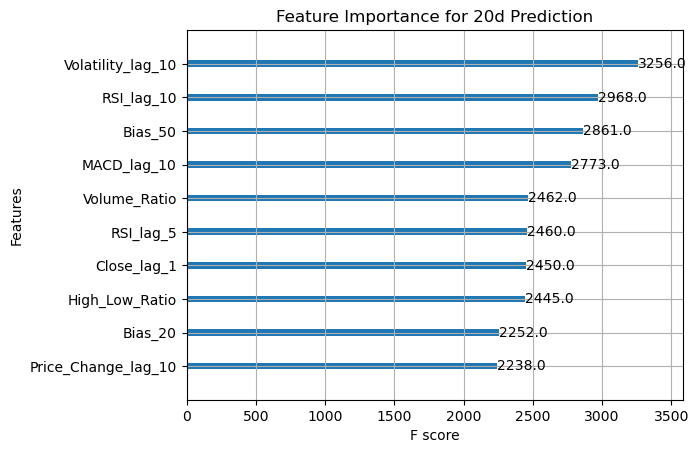

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


param_grid = {
    'n_estimators': [100, 300, 500],       
    'max_depth': [5, 7, 9],                
    'learning_rate': [0.01, 0.05, 0.1],     
    'subsample': [0.8],                     
    'colsample_bytree': [0.8]             
}

for d in [20]:
    
    tscv = TimeSeriesSplit(n_splits=3)  #0112

    target_col = f'Future_Up_{d}d'
    y_train = train_df_new[target_col]
    y_test = test_df_new[target_col]
    
    current_ratio = (y_train == 0).sum() / (y_train == 1).sum()
    
    model_optimized2 = XGBClassifier(
    scale_pos_weight=current_ratio,
    random_state=42,
    eval_metric='logloss'
    )
    
    
    # Gridsearch
    grid_search = GridSearchCV(
        estimator=model_optimized2, 
        param_grid=param_grid, 
        scoring='f1',           
        cv=tscv,  #0112 
        verbose=1,              
        n_jobs=2
    )

    
    # Best solution
    print(f"\n Finding optimal parameters for {d}day prediction, please wait...")
    grid_search.fit(X_train_opt, y_train)

    # Result
    print("-" * 30)
    print(f"[{d}天] Best combination: {grid_search.best_params_}")
    print(f"[{d}天] Highest F1 Score: {grid_search.best_score_:.4f}")
    
    # 6. Prediction test data
    best_model = grid_search.best_estimator_
    y_pred_final = best_model.predict(X_test_opt)

    acc = accuracy_score(y_test, y_pred_final)
    ones = sum(y_pred_final)
    zeros = len(y_pred_final) - ones
    print(f"--- {d}天调优后报告 ---")
    print(f"准确率: {acc:.2%}")
    print(f"预测结果分布: 预测涨(1)共 {ones} 次, 预测跌(0)共 {zeros} 次\n")
    print(f"\n" + "="*50)
    print(f"【{d}天预测任务】 详细评估报告：")
    print(classification_report(y_test,y_pred_final))

    plt.figure(figsize=(10, 8))
    plot_importance(best_model, max_num_features=10, title=f'Feature Importance for {d}d Prediction')
    plt.show()


[20 days prediction] Test ROC AUC: 0.5291


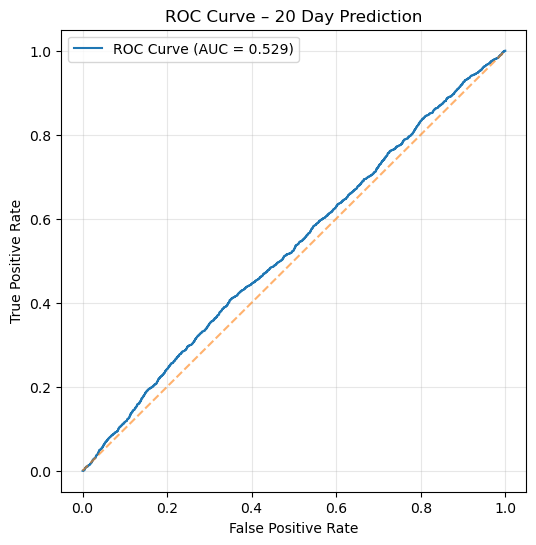

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Export the best model
y_proba_test = best_model.predict_proba(X_test_opt)[:, 1]

# 2. ROC AUC calculate
roc_auc = roc_auc_score(y_test, y_proba_test)
print(f"[20 days prediction] Test ROC AUC: {roc_auc:.4f}")

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – 20 Day Prediction")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
